In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from uuid import uuid4

import pandas as pd
import numpy as np
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from tqdm.auto import tqdm
import torch

sys.path.append("..")
from sgs_utils.path_conf import (
    loc_data_dir,
    speech_data_session_dir,
    interim_speech_data_dir,
)
from sgs_utils.data_filtering import (
    _silent_recording_mask,
    _noisy_recording_mask,
    _skip_id_mask,
    get_valid_audio_mask,
    _silent_end_mask,
)

import seaborn as sns
import plotly.express as px

sns.set_context("talk")


from sklearn.manifold import TSNE


In [3]:
df_session = pd.read_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned_VAD.parquet")
)


#  `ECAPA-TDNN` embeddings (*Full duration*)

In [4]:
extracted_embeddings = True


In [5]:
if not extracted_embeddings:
    # These are temporary uuid's to use a primary key for linkage with the
    # ECAPA TDNN embeddings
    df_session["uuid"] = [str(uuid4()) for _ in range(len(df_session))]

    # load the ECAPA-TDNN classifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb"
    )

    if torch.cuda.is_available():
        print(torch.cuda.get_device_name())
        classifier = classifier.cuda()
        classifier.device = f"cuda:{torch.cuda.current_device()}"
        print(classifier.device)

    uuid_embedding = {}

    for _, row in tqdm(
        list(df_session[df_session.VAD_sliced_duration_s > 15].iterrows())
    ):
        arr_path = (
            interim_speech_data_dir
            / "VAD_slice_16khz"
            / row.ID
            / row.DB
            / f"{row.pic_name}__{row.time_str}.npy"
        )
        if not arr_path.exists():
            continue

        signal, fs = torch.tensor(np.load(arr_path).reshape(1, 1, -1)), 16_000

        # Encode via
        if signal.size()[0] == 0:
            continue
        # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
        # desired format of the ECAPA-TDNN architecture
        uuid_embedding[row.uuid] = (
            classifier.encode_batch(classifier.audio_normalizer(signal, fs))
            .cpu()
            .numpy()
            .ravel()
        )

    df_emb = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
    df_emb.index.name = "uuid"
    df_emb.index = df_emb.index.astype("str")
    df_emb = df_emb.reset_index(drop=False)
    df_emb = df_emb.merge(df_session, on="uuid", how="left")
    df_emb = df_emb[["ID", "DB", "time_str"] + list(df_emb.filter(like="emb_").columns)]

    df_session.drop(columns="uuid", inplace=True)

    del row, signal, fs, uuid_embedding

    df_emb.to_parquet(loc_data_dir.joinpath("ECAPA_TDNN_emb.parquet"))

else:
    df_emb = pd.read_parquet(loc_data_dir.joinpath("ECAPA_TDNN_emb.parquet"))


## Merge the embeddings with the session data

In [6]:
df_emb_tot = pd.merge(df_session, df_emb.reset_index(), on=["ID", "DB", "time_str"])
df_emb_tot["speech_style"] = df_emb_tot.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

df_emb_tot.filter(like="emb_").head(n=3)


emb_0      emb_1     emb_2      emb_3      emb_4      emb_5      emb_6  \
0   9.211899   7.184010  6.942975  33.333511   7.307597 -31.459921  39.044449   
1  18.842535  16.677446  9.552917  42.255661   6.559439 -32.258068  48.416634   
2  22.300203  17.258266  7.822000  27.619843  17.469421 -39.157970  58.856373   

       emb_7      emb_8      emb_9  ...    emb_182    emb_183    emb_184  \
0  31.211269 -15.251102   4.482396  ... -14.955734  -1.935985   2.211924   
1  43.726734  -7.949045 -23.850367  ... -21.021570  12.306584   0.100198   
2  29.111202  -9.096043 -33.353394  ... -17.402655  14.551467 -12.623632   

    emb_185    emb_186    emb_187    emb_188    emb_189   emb_190    emb_191  
0  3.692186 -27.086611 -13.301306  23.004284 -25.920155  0.850327 -10.741280  
1 -4.748908 -25.429121  -9.454414  32.216736 -18.768064  1.384200 -10.027575  
2 -2.571703 -19.677940  -8.366760  21.044867 -15.711094  4.545811 -17.256887  

[3 rows x 192 columns]

In [7]:
valid_mask = (
    (df_emb_tot["VAD_sliced_duration_s"] > 15)
    & ~_silent_recording_mask(df_emb_tot)
    & ~_noisy_recording_mask(df_emb_tot)
    & ~_skip_id_mask(df_emb_tot)
)
print(f"{sum(valid_mask)} / {len(valid_mask)}")
df_emb_tot_v = df_emb_tot[get_valid_audio_mask(df_emb_tot)].reset_index(drop=True)
del df_emb_tot


2903 / 2909


## Embedding Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [8]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(
    n_components, perplexity=200, learning_rate="auto", init="pca"
)  # perplexity = # allowed nearest neighbours
tsne_result = tsne.fit_transform(df_emb_tot_v.filter(like="emb_"))


def construct_tsne_df(tnse_result: np.ndarray) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tnse_result).add_prefix("tsne_")
    for c in [
        "pic_name",
        "timestamp",
        "wav_timestamp",
        "wav_duration_s",
        "ID",
        "DB",
        "sex",
        "age",
        "speech_style",
    ]:
        tsne_result_df[c] = df_emb_tot_v[c]
    return tsne_result_df


/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


## Visualize TSNE

In [9]:
px.scatter(
    construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    color="ID",
    hover_data=["timestamp", "pic_name", "wav_timestamp"],
    opacity=0.5,
    height=850,
    template="plotly_white",
)


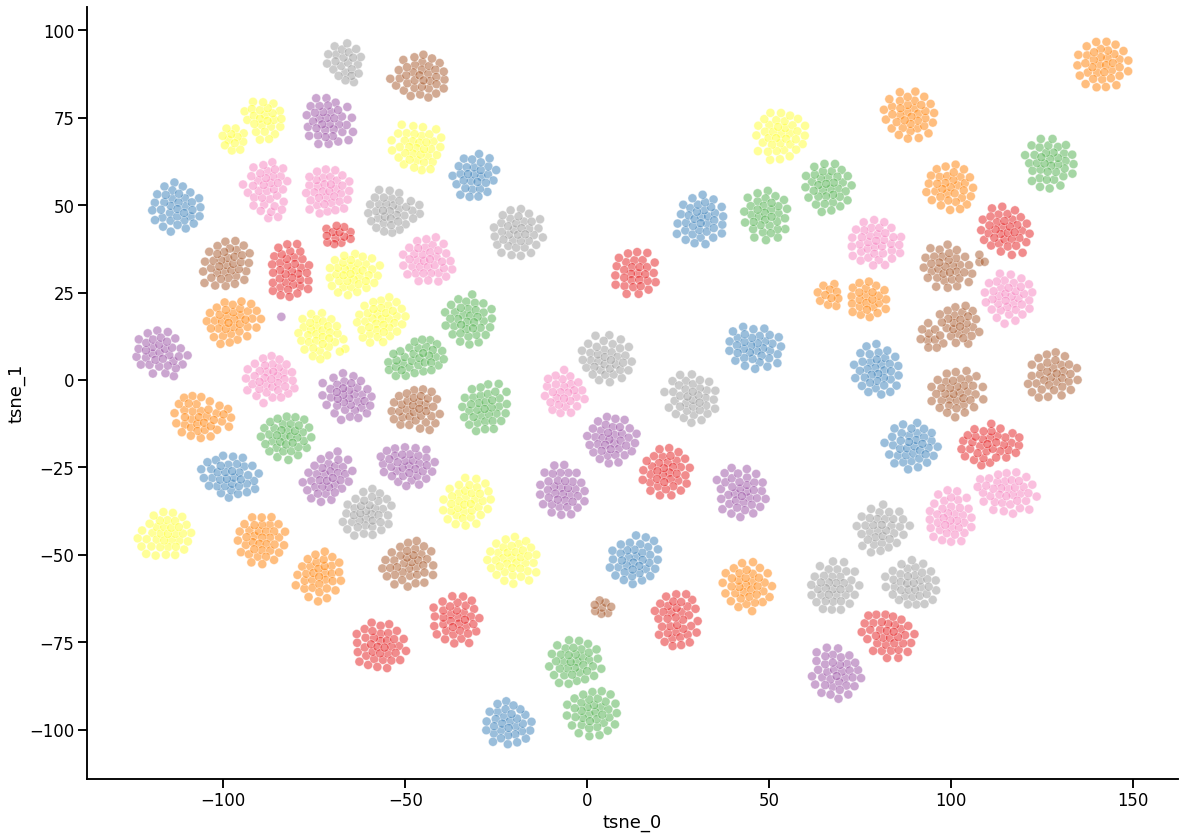

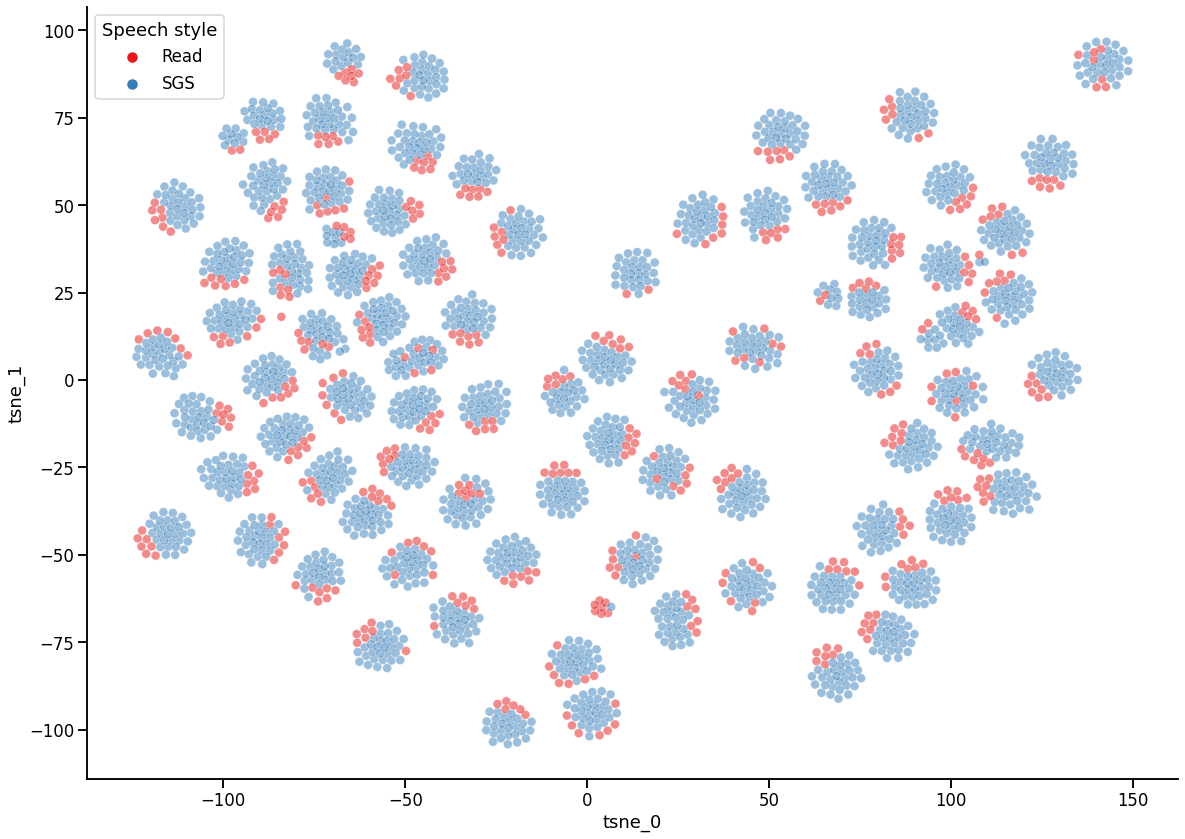

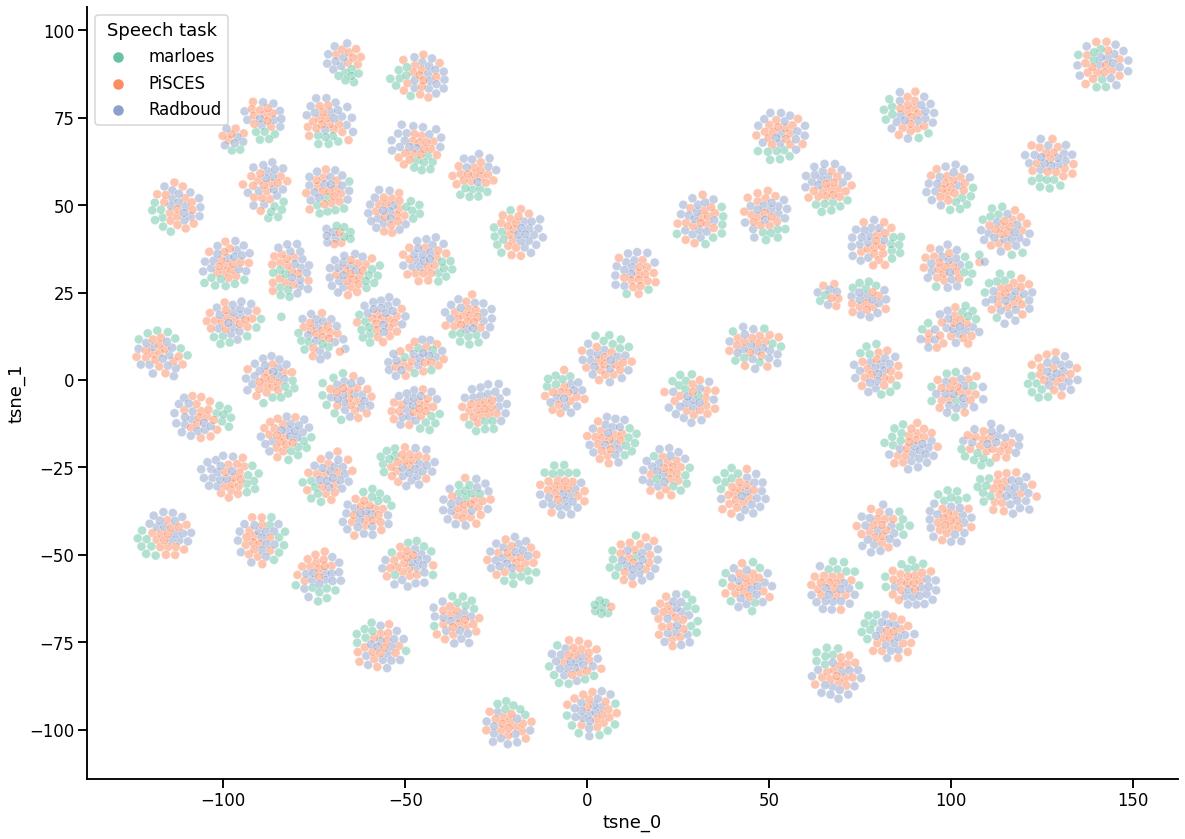

In [10]:

# Hue == ID
g = sns.relplot(
    data=construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    hue="ID",
    height=12,
    kind="scatter",
    palette="Set1",
    aspect=1.4,
    legend=False,
    alpha=.5,
)

# Hue == speech style
g = sns.relplot(
    data=construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    hue="speech_style",
    height=12,
    kind="scatter",
    palette="Set1", #  sns.color_palette('Set3')[0] +sns.color_palette('Set3')[2:3],
    aspect=1.4,
    alpha=.5,
    facet_kws=dict(legend_out=False),
)
g.legend.set_title('Speech style')

# Hue == speech task
g = sns.relplot(
    data=construct_tsne_df(tsne_result  ),
    x="tsne_0",
    y="tsne_1",
    hue="DB",
    height=12,
    kind="scatter",
    palette="Set2",
    aspect=1.4,
    alpha=.5,
    facet_kws=dict(legend_out=False),
)
g.legend.set_title('Speech task')

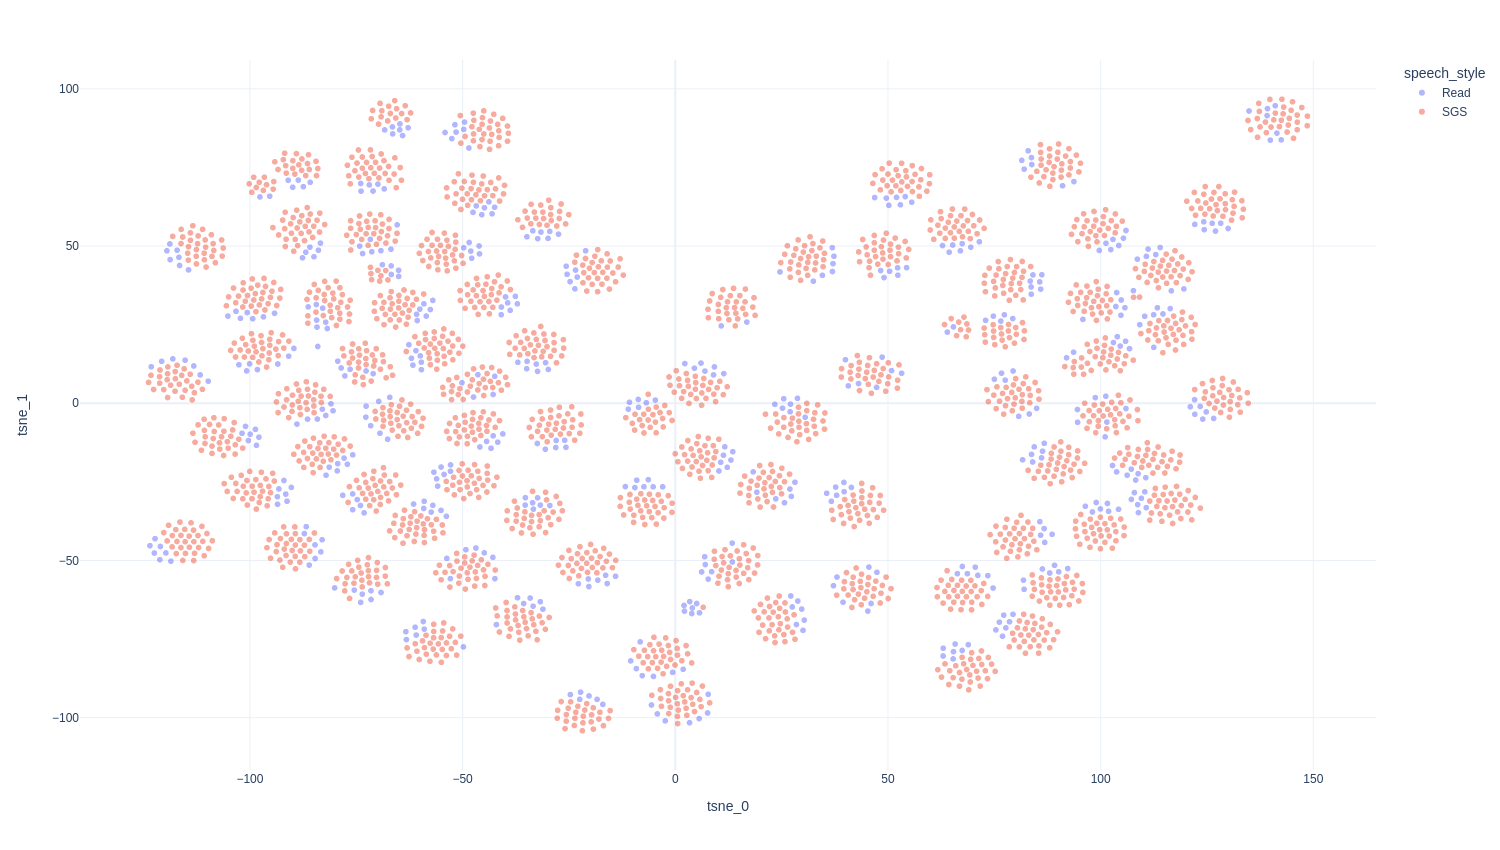

In [11]:
px.scatter(
    construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    color="speech_style",
    hover_data=["ID", "timestamp", "pic_name", "wav_timestamp"],
    opacity=0.5,
    height=850,
    template="plotly_white",
).show(renderer='png', width=1500, height=850)


# Machine learning: testing `speech-style` seperability 

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt


In [13]:
df_emb_tot_v["speech_style"].values


array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [14]:
model = Pipeline(
    [
        ("scaling", PowerTransformer()),
        ("lr", LogisticRegression(C=0.1, max_iter=200, solver="liblinear")),
    ]
)

cvs = cross_val_score(
    estimator=model,
    X=df_emb_tot_v.filter(like="emb_"),
    y=df_emb_tot_v["speech_style"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_emb_tot_v["ID"],
)
print(cvs.round(3))
print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")


[0.843 0.861 0.835 0.806 0.808]
0.83±0.021


In [15]:
X = df_emb_tot_v.filter(like="emb_").values
y = df_emb_tot_v["speech_style"].values
groups = df_emb_tot_v["ID"]


              precision    recall  f1-score   support

        Read       0.60      0.81      0.69       113
         SGS       0.95      0.87      0.91       473

    accuracy                           0.86       586
   macro avg       0.78      0.84      0.80       586
weighted avg       0.88      0.86      0.87       586



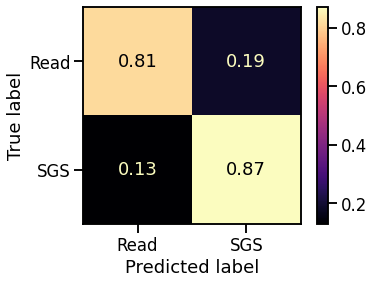

              precision    recall  f1-score   support

        Read       0.63      0.83      0.72       109
         SGS       0.96      0.89      0.92       469

    accuracy                           0.88       578
   macro avg       0.80      0.86      0.82       578
weighted avg       0.90      0.88      0.88       578



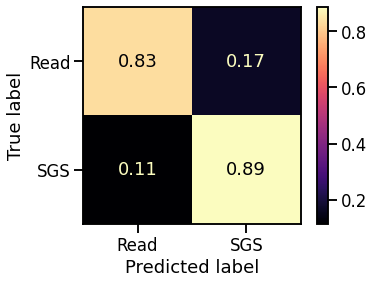

              precision    recall  f1-score   support

        Read       0.66      0.76      0.71       109
         SGS       0.94      0.91      0.92       467

    accuracy                           0.88       576
   macro avg       0.80      0.83      0.82       576
weighted avg       0.89      0.88      0.88       576



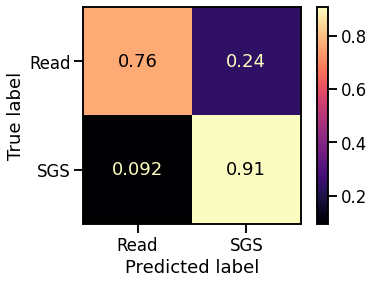

              precision    recall  f1-score   support

        Read       0.49      0.81      0.61       108
         SGS       0.95      0.81      0.87       471

    accuracy                           0.81       579
   macro avg       0.72      0.81      0.74       579
weighted avg       0.86      0.81      0.82       579



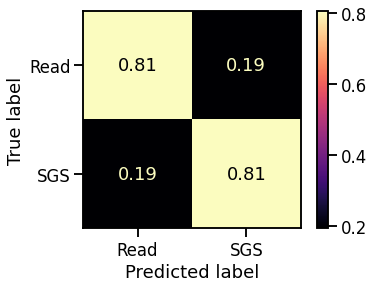

              precision    recall  f1-score   support

        Read       0.57      0.76      0.65       115
         SGS       0.94      0.86      0.90       469

    accuracy                           0.84       584
   macro avg       0.75      0.81      0.77       584
weighted avg       0.86      0.84      0.85       584



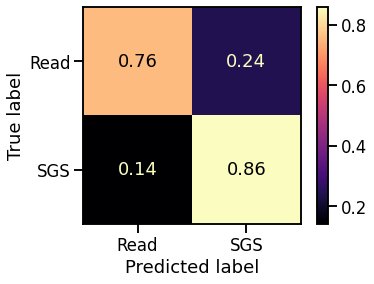

In [16]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(
        model, x_test_cv_, y[test_idx], normalize="true", cmap="magma"
    )
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    # aucs += [roc_auc_score(y[test_idx], preds_proba)]


---

In [17]:
torch.cuda.empty_cache()  # PyTorch thing


# Extract `ECAPA TDNN` embeddings - *Fixed duration*

In [18]:
DUR_S = 15
START_FROM_END = True
extracted_embeddings = True 


In [19]:
if not extracted_embeddings:
    # load the ECAPA-TDNN classifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb"
    )

    if torch.cuda.is_available():
        print(torch.cuda.get_device_name())
        classifier = classifier.cuda()
        classifier.device = f"cuda:{torch.cuda.current_device()}"
        print(classifier.device)

    # These are temporary uuid's to use a primary key for linkage with the
    # ECAPA TDNN embeddings
    df_session["uuid"] = [str(uuid4()) for _ in range(len(df_session))]

    uuid_embedding = {}
    for _, row in tqdm(
        list(df_session[df_session.VAD_sliced_duration_s > DUR_S].iterrows())
    ):
        arr_path = (
            interim_speech_data_dir
            / "VAD_slice_16khz"
            / row.ID
            / row.DB
            / f"{row.pic_name}__{row.time_str}.npy"
        )
        if not arr_path.exists():
            continue

        signal, fs = torch.tensor(np.load(arr_path)), 16_000

        preferred_offset_s = 5
        if row.VAD_sliced_duration_s < (DUR_S + 1):
            continue

        # slice the signal to the correct duration
        # (we do not use the first 0.5 second and the last second)
        if START_FROM_END:
            signal = signal[int((row.VAD_sliced_duration_s -  DUR_S) * fs):]
        else:
            signal = signal[:int(DUR_S * fs)]

        # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
        # desired format of the ECAPA-TDNN architecture
        uuid_embedding[row.uuid] = (
            classifier.encode_batch(classifier.audio_normalizer(signal, fs))
            .cpu()
            .numpy()
            .ravel()
        )

    df_emb_fixed_dur = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
    df_emb_fixed_dur.index.name = "uuid"
    df_emb_fixed_dur.index = df_emb_fixed_dur.index.astype("str")
    df_emb_fixed_dur = df_emb_fixed_dur.reset_index(drop=False)
    df_emb_fixed_dur = df_emb_fixed_dur.merge(df_session, on="uuid", how="left")
    df_emb_fixed_dur = df_emb_fixed_dur[
        ["ID", "DB", "time_str"] + list(df_emb_fixed_dur.filter(like="emb_").columns)
    ]

    # These are temporary uuid's to use a primary key for linkage with the
    # ECAPA TDNN embeddings
    df_session["uuid"] = [str(uuid4()) for _ in range(len(df_session))]

    # del row, signal, fs, uuid_embedding
    df_emb_fixed_dur.to_parquet(
        loc_data_dir.joinpath(
            f"ECAPA_TDNN_emb_{DUR_S}s_{'end' if START_FROM_END else 'start'}.parquet"
        )
    )

else:
    df_emb_fixed_dur = pd.read_parquet(
        loc_data_dir.joinpath(
            f"ECAPA_TDNN_emb_{DUR_S}s_{'end' if START_FROM_END else 'start'}.parquet"
        )
    )


## Merge the embeddings with the session data

In [20]:
df_emb_tot_fd = pd.merge(
    df_emb_fixed_dur.reset_index(), df_session, on=["ID", "DB", "time_str"], how="left"
)
df_emb_tot_fd["speech_style"] = df_emb_tot_fd.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

display(df_emb_tot_fd.filter(like="emb_").head(n=3))

valid_mask = (
    (df_emb_tot_fd["VAD_sliced_duration_s"] > 15)
    & ~_silent_recording_mask(df_emb_tot_fd)
    & ~_noisy_recording_mask(df_emb_tot_fd)
    & ~_skip_id_mask(df_emb_tot_fd)
    & ~_silent_end_mask(df_emb_tot_fd)
)
display(valid_mask.value_counts())
df_emb_tot_fd_v = df_emb_tot_fd[valid_mask].reset_index(drop=True)

del df_emb_tot_fd


emb_0      emb_1      emb_2      emb_3      emb_4      emb_5  \
0  13.378369   5.075369   4.533211  29.059380  10.161418 -31.532131   
1  45.246288   7.808414  21.708130  49.428993   3.101873 -32.727627   
2  10.446198  25.974710   0.455513  18.914436  18.945549 -39.623837   

       emb_6      emb_7      emb_8      emb_9  ...    emb_182    emb_183  \
0  36.100807  31.203058 -17.041925   4.007894  ... -13.050153  -7.929780   
1  51.202335  41.120346 -21.768900 -16.387732  ... -37.776661  10.576370   
2  59.506676  14.922482   0.568791 -31.227816  ... -11.812667  18.464415   

     emb_184   emb_185    emb_186    emb_187    emb_188    emb_189   emb_190  \
0   4.927083  8.524666 -27.655039 -14.364986  18.858124 -25.379114 -3.493644   
1 -11.535968  1.279633  -8.434257 -10.161257   9.505790 -20.384161 -2.180710   
2 -21.993093 -1.278931 -20.846292 -11.062707  21.199602  -9.282084  4.502911   

     emb_191  
0  -9.196476  
1 -12.127472  
2 -21.108011  

[3 rows x 192 columns]

True     2887
False       8
dtype: int64

## Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [21]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(
    n_components, perplexity=200, init="pca", learning_rate="auto"
)  # perplexity = # allowed nearest neighbours
tsne_result_fd = tsne.fit_transform(df_emb_tot_fd_v.filter(like="emb_"))


/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [22]:
def construct_tsne_df(tnse_result: np.ndarray) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tnse_result).add_prefix("tsne_")
    for c in [
        "pic_name",
        "timestamp",
        "wav_timestamp",
        "time_str",
        "wav_duration_s",
        "ID",
        "DB",
        "sex",
        "age",
        "speech_style",
    ]:
        tsne_result_df[c] = df_emb_tot_fd_v[c]
    return tsne_result_df


## Visualize TSNE

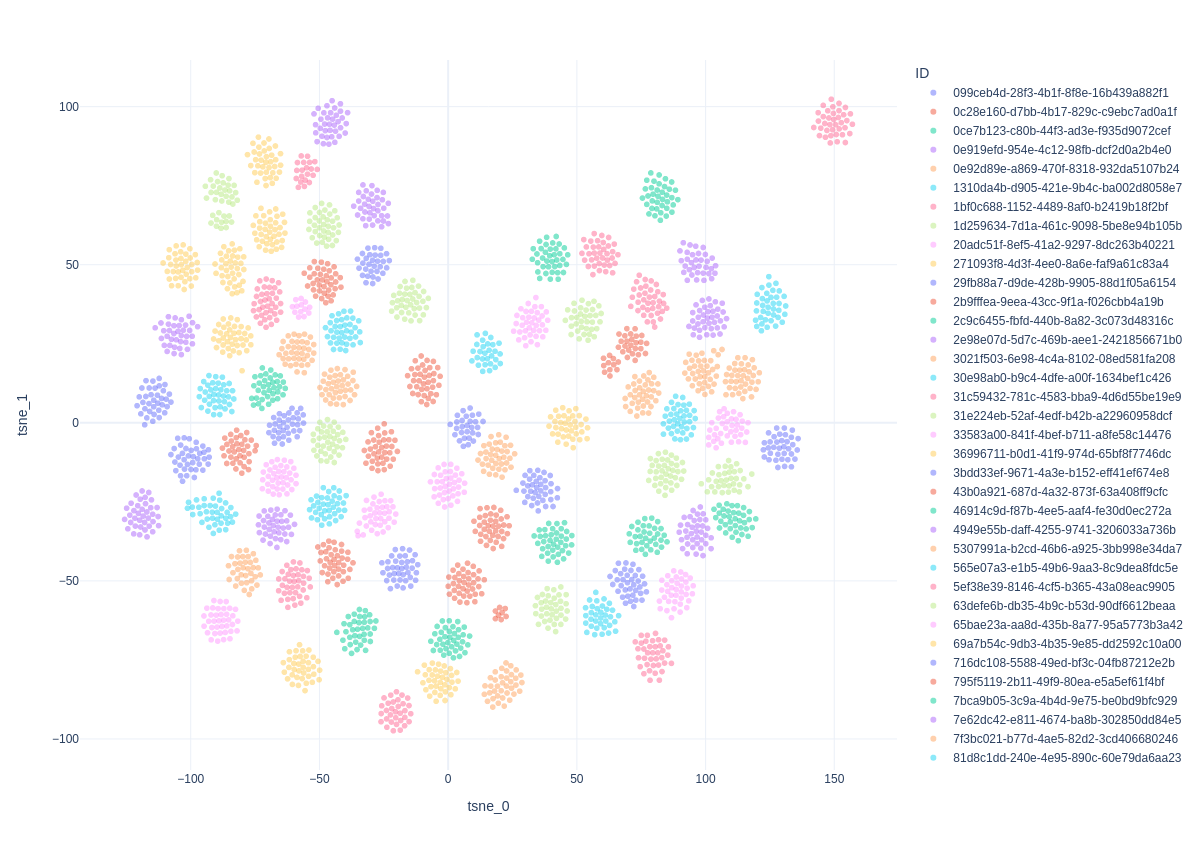

In [23]:
px.scatter(
    construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    color="ID",
    hover_data=["timestamp", "pic_name", "wav_timestamp", "time_str"],
    opacity=0.5,
    height=850,
    template="plotly_white",
).show(renderer='png', width=1200, height=850)


In [24]:
# px.scatter(
#     construct_tsne_df(tsne_result_fd),
#     x="tsne_0",
#     y="tsne_1",
#     color="speech_style",
#     hover_data=["ID", "pic_name", "time_str"],
#     opacity=0.5,
#     template="plotly_white",
#     height=850,
# ).show(renderer='png', width=1200, height=800)


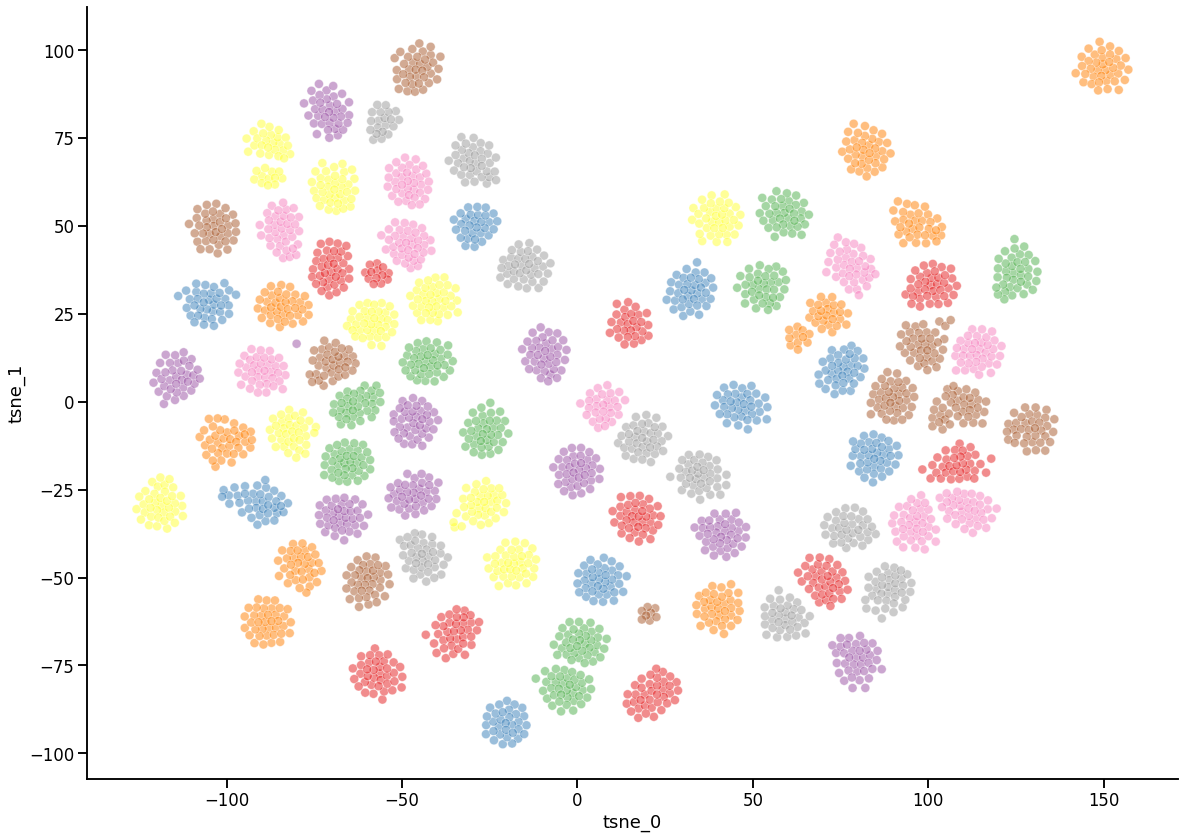

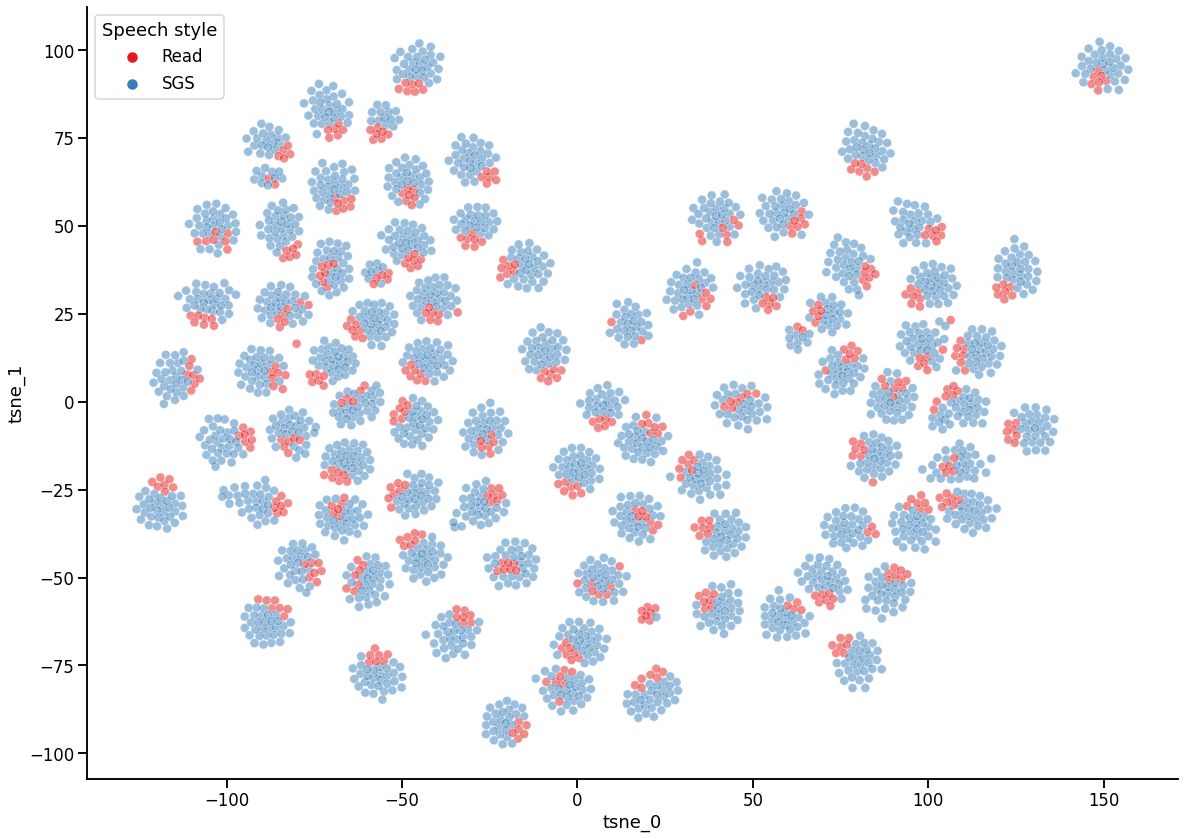

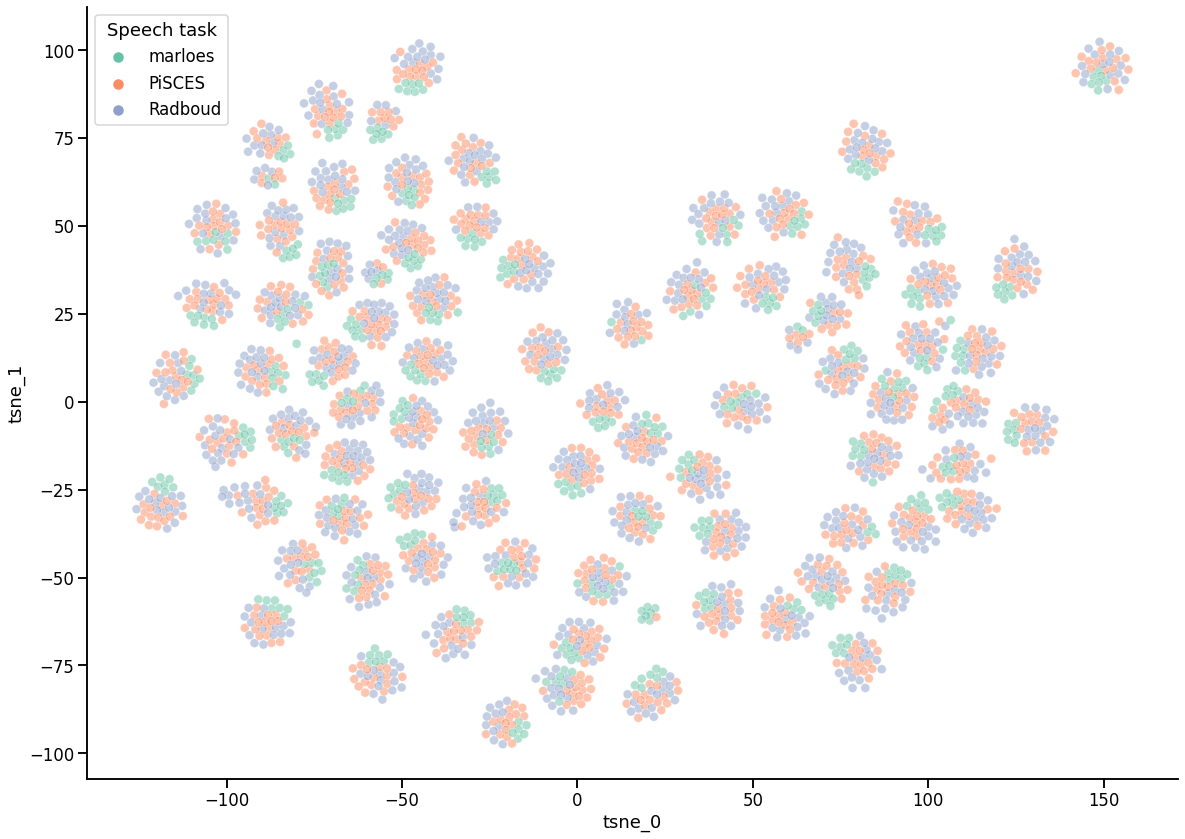

In [25]:
# Hue == ID
g = sns.relplot(
    data=construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    hue="ID",
    height=12,
    kind="scatter",
    palette="Set1",
    aspect=1.4,
    legend=False,
    alpha=.5,
)
g.savefig("../reports/ECAPA_TDNN_tsne_ID.pdf", bbox_inches="tight", dpi=250)
g.savefig("../reports/ECAPA_TDNN_tsne_ID.png", bbox_inches="tight", dpi=250)


# Hue == speech style
g = sns.relplot(
    data=construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    hue="speech_style",
    height=12,
    kind="scatter",
    palette="Set1", #  sns.color_palette('Set3')[0] +sns.color_palette('Set3')[2:3],
    aspect=1.4,
    alpha=.5,
    facet_kws=dict(legend_out=False),
)
g.legend.set_title('Speech style')
g.savefig("../reports/ECAPA_TDNN_tsne_speech_style.pdf", bbox_inches="tight", dpi=250)
g.savefig("../reports/ECAPA_TDNN_tsne_speech_style.png", bbox_inches="tight", dpi=250)


# Hue == speech task
g = sns.relplot(
    data=construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    hue="DB",
    height=12,
    kind="scatter",
    palette="Set2",
    aspect=1.4,
    alpha=.5,
    facet_kws=dict(legend_out=False),
)
g.legend.set_title('Speech task')

# Testing `speech-style` seperability 

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt


In [27]:
df_emb_tot_fd_v["speech_style"].values


array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [28]:
model = Pipeline(
    [
        ("scaling", PowerTransformer()),
        ("lr", LogisticRegression(C=0.1, solver="liblinear", max_iter=200)),
    ]
)

cvs = cross_val_score(
    estimator=model,
    X=df_emb_tot_fd_v.filter(like="emb_"),
    y=df_emb_tot_fd_v["speech_style"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_emb_tot_fd_v["ID"],
)
print(cvs.round(3))
print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")


/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning:

overflow encountered in reduce

/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning:

overflow encountered in reduce

/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning:

overflow encountered in reduce



[0.813 0.82  0.875 0.871 0.82 ]
0.84±0.027


In [29]:
X = df_emb_tot_fd_v.filter(like="emb_").values
y = df_emb_tot_fd_v["speech_style"].values
groups = df_emb_tot_fd_v["ID"]


df_emb_tot_fd_v["speech_style_pred"] = None


/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning:

overflow encountered in reduce



              precision    recall  f1-score   support

        Read       0.54      0.78      0.64       108
         SGS       0.94      0.85      0.89       469

    accuracy                           0.84       577
   macro avg       0.74      0.81      0.77       577
weighted avg       0.87      0.84      0.85       577



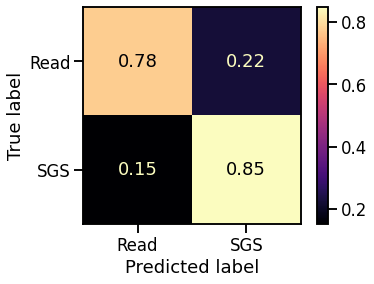

/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning:

overflow encountered in reduce



              precision    recall  f1-score   support

        Read       0.51      0.83      0.64       115
         SGS       0.95      0.80      0.87       465

    accuracy                           0.81       580
   macro avg       0.73      0.82      0.75       580
weighted avg       0.86      0.81      0.82       580



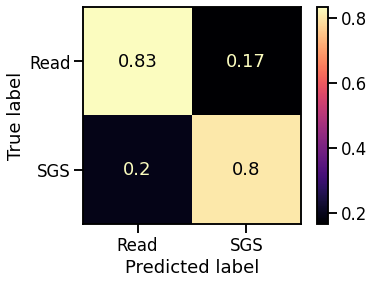

/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning:

overflow encountered in reduce



              precision    recall  f1-score   support

        Read       0.87      0.78      0.82       108
         SGS       0.95      0.97      0.96       469

    accuracy                           0.94       577
   macro avg       0.91      0.88      0.89       577
weighted avg       0.93      0.94      0.93       577



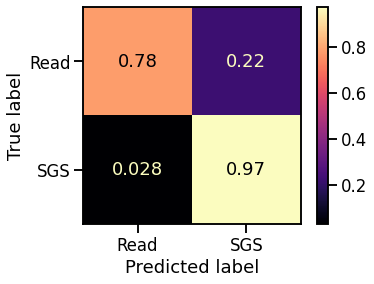

              precision    recall  f1-score   support

        Read       0.70      0.82      0.76       108
         SGS       0.96      0.92      0.94       466

    accuracy                           0.90       574
   macro avg       0.83      0.87      0.85       574
weighted avg       0.91      0.90      0.90       574



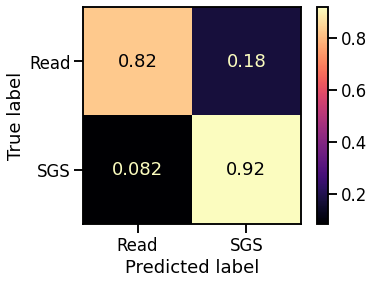

              precision    recall  f1-score   support

        Read       0.78      0.69      0.73       108
         SGS       0.93      0.96      0.94       471

    accuracy                           0.91       579
   macro avg       0.85      0.82      0.84       579
weighted avg       0.90      0.91      0.90       579



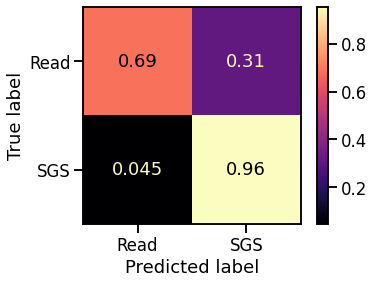

MF1 [0.766 0.754 0.89  0.848 0.836]
0.819±0.051
AUC [0.863 0.897 0.968 0.943 0.953]
0.925±0.039


In [30]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    df_emb_tot_fd_v.iloc[
        test_idx, df_emb_tot_fd_v.columns.get_loc("speech_style_pred")
    ] = preds
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(
        model, x_test_cv_, y[test_idx], normalize="true", cmap="magma"
    )
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    aucs += [roc_auc_score(y[test_idx], preds_proba)]

mf1s = np.array(mf1s)
print("MF1", mf1s.round(3))
print(f"{mf1s.mean().round(3)}±{mf1s.std().round(3)}")
aucs = np.array(aucs)
print("AUC", aucs.round(3))
print(f"{aucs.mean().round(3)}±{aucs.std().round(3)}")


In [31]:
df_emb_tot_fd_v["misprediction"] = (
    df_emb_tot_fd_v["speech_style"] != df_emb_tot_fd_v["speech_style_pred"]
)


In [32]:
df_emb_tot_fd_v.groupby("ID")["misprediction"].sum().sort_values(ascending=False)


ID
2b9fffea-9eea-43cc-9f1a-f026cbb4a19b    27
9223720f-1a2a-4811-84a1-a421646f63a0    22
1bf0c688-1152-4489-8af0-b2419b18f2bf    20
b175704a-f30d-4143-a3b5-5cbd779b7859    16
fb807c80-22cc-4964-81a0-8c732f572004    16
                                        ..
bab663ff-0b70-4dc3-ab87-fe09f2b79959     0
94025116-4e19-4718-9e4e-c9f5af205b4c     0
2c9c6455-fbfd-440b-8a82-3c073d48316c     0
a8fda205-f95f-4b90-b2b1-7b1c59af2f45     0
31e224eb-52af-4edf-b42b-a22960958dcf     0
Name: misprediction, Length: 82, dtype: int64

<AxesSubplot:>

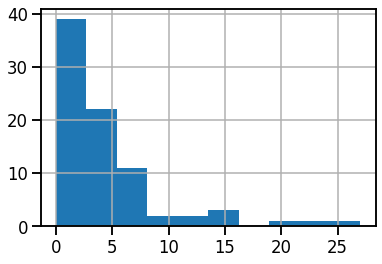

In [33]:
df_emb_tot_fd_v.groupby("ID")["misprediction"].sum().hist()


In [34]:
# df_emb_tot_fd_v[(df_emb_tot_fd_v.ID == "2b9fffea-9eea-43cc-9f1a-f026cbb4a19b")][
#     [
#         "timestamp",
#         "wav_timestamp",
#         "DB",
#         "pic_name",
#         "wav_duration_s",
#         "speech_style",
#         "speech_style_pred",
#         "misprediction",
#     ]
# ]


In [35]:
# df_emb_tot_fd_v[(df_emb_tot_fd_v.ID == "1bf0c688-1152-4489-8af0-b2419b18f2bf")][
#     [
#         "wav_timestamp",
#         "DB",
#         "pic_name",
#         "wav_duration_s",
#         "speech_style",
#         "speech_style_pred",
#         "misprediction",
#     ]
# ]


In [36]:
# df_emb_tot_fd_v[(df_emb_tot_fd_v.ID == "9223720f-1a2a-4811-84a1-a421646f63a0")][
#     [
#         "timestamp",
#         "wav_timestamp",
#         "DB",
#         "pic_name",
#         "wav_duration_s",
#         "speech_style",
#         "speech_style_pred",
#         "misprediction",
#     ]
# ]
